
#**Human activity recognition with accelerometers and gyroscopes**

---

The present notebook introduces a novel algorithm for human activity recognition. The algorithm tested on the DaiLAc (daily living activities) [dataset](https://www.mad.tf.fau.de/research/activitynet/daliac-daily-life-activities). The dataset contains accelerometer and gyrometer data  collected from 19 subjects while performing 13 distinct daily activiies :

*   Sitting
*   Lying
*   Standing
*   Washing dishes
*   Vacuuming
*   Sweeping
*   Walking outside
*   Ascending stairs
*   Descending stairs
*   Treadmill running (8.3 km/h)
*   Bicycling (50 watt)
*   Bicycling (100 watt)
*   Rope jumping

The algorithm shows how one can achieve a comparatively high classification accuracy with a careful preprocessing of the raw signals and feature engeneering. 

**Imports and directory setting**

In [0]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/My\ Drive/Dailac/
from har_utils import * # module containing customized function
from sklearn.preprocessing import StandardScaler
import os

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


**Names and Parameters**

In [0]:
activities = ["sit", "lie", "stand", "dishes", "vacuum", "sweep",
              "walk", "stairs_up", "stairs_down", "run",
              "bike_50W", "bike_100W", "jump"]
devices = ["A_wrist", "G_wrist", "A_chest", "G_chest",
           "A_hip", "G_hip",  "A_ankle", "G_ankle"]#device names
locations = ["wrist", "chest", "hip", "ankle"]# device locations
colnames = [dev + "_" + str(i) for dev in devices for i in range(1,4)] + ["label"] #signal names
a_cols = ["A_" in x for x in colnames]
g_cols = ["G_" in x for x in colnames]
sf = 204.8/4 #samling frequency
wl = int(sf*5)#window length
ol = wl//2 #window overlap (50%)
n_subjs = 19
n_cols = 48 #no. of columns for signals
n_features = 25 # no. of features per signal

**Reading and pre-processing**

---

Raw data by subject are read from the /Data file using Pandas and processed as follows:

*   We isolate the accelerometer signal to low-pass and high-pas filter it (AC and DC components) using the custom function *get_AC_DC()*.
*   All signals are standardized using the sklearn *StandardScaler()*.
*   We concatenate all signals (accelerometer, gyroscopes, AC and DC).
*   Each signal is segmented to windows with a 50% overlap and reshaped into a 3D arrays (# windows, # datapoints per window). Windowed signals are then concatenated along a third axis (# signals).
*   Last, the windowed signals are Fourier transformed.



In [0]:
import pandas as pd
scaler = StandardScaler()
#list to store data by subject
SIGNALS = []
FT = []
Y = []

for subj in range(n_subjs): 
  #reading
  raw = pd.read_csv("dailac/dataset_" + str(subj+1) + ".txt",
                  names = colnames, index_col = False)
  raw = raw.iloc[::4, :]#resampling
  raw.reset_index(inplace = True, drop = True)
  y = raw.label.values
  #extracting AC and DC components and concatenating
  acc = raw.loc[:, a_cols]
  AC, DC = get_AC_DC(acc.values, sf, 1,2)
  gyros = raw.loc[:, g_cols]
  X = pd.concat([acc, gyros, AC, DC], axis = 1)
  #rescale
  X = scaler.fit_transform(X)
  #reshaping labels
  y = reshape_to_windows(y, wl, ol)[:, wl//2] #labels at center of window

  #empty arrays for raw data, fourier transformed data
  signals = np.zeros((y.shape[0], wl, n_cols))
  ft = np.empty((y.shape[0], wl, n_cols), np.complexfloating)
  #reshaping signals and taking Fourier transform
  for col in range(X.shape[1]):
    x = reshape_to_windows(X[:,col], wl, ol)
    x_ft = np.fft.fft2(x-np.mean(x, axis = 1)[:,None])/wl
    signals[:, :, col] = x
    ft[:, :, col] = x_ft
  
  SIGNALS.append(signals)
  FT.append(ft)
  Y.append(y)



**Visualization of the problem at hand**

Below we plot, for subject 0, samples of acceleration and angular velocity recorded along the first axis of the ankle device for all the activities studied. Although only the data of one device along one axis is plotted, we can already see that the activities present different magnitudes and patterns in their data, except for different bunches of activities exhibiting a high degree of similarity: standing and doing the dishes, vacuum cleaning and sweeping, walking and ascending/descending the stairs, and biking with 50 or 100 Watt resistance. 

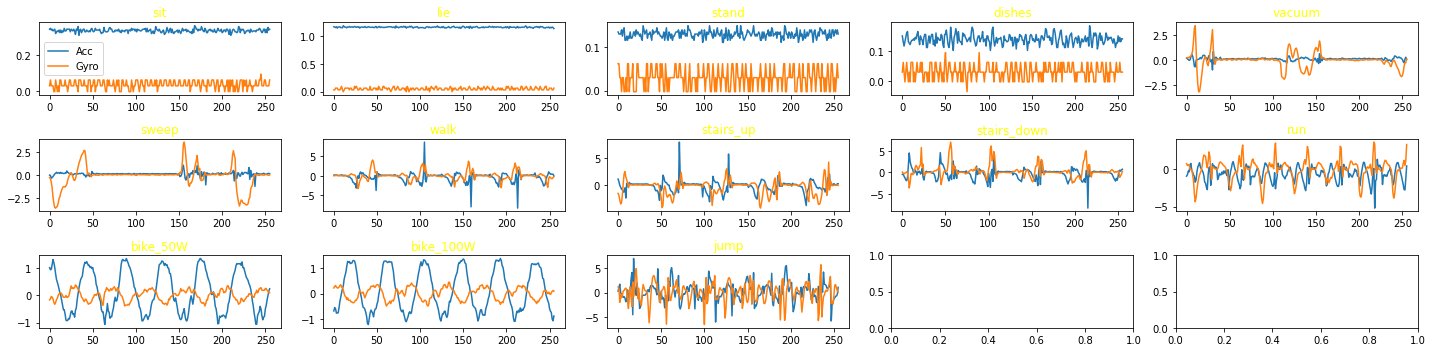

In [0]:
final_cols = np.char.array([sig + "_"+ loc +'_' + str(ax)\
              for sig in ("A", "G", "AC", "DC")\
              for loc in locations\
              for ax in range(1,4)])#column index
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,5, figsize = (20,5))
for i, act in enumerate(activities):
  act_ex = np.where(Y[0]==i+1)[0][10]#10th window of activity for subject 0
  ax[i//5, i%5].plot(SIGNALS[0][act_ex, :, final_cols=="A_ankle_1"][0,:], label = "Acc")
  ax[i//5, i%5].plot(SIGNALS[0][act_ex, :, final_cols=="G_ankle_1"][0,:], label = "Gyro")
  ax[0,0].legend()
  ax[i//5, i%5].set_title(act, {'color':"yellow"})
fig.tight_layout()


**Visualization of processed data**

This plot illustrates a sequence (1 window) of biking (coded 12) with the four types of signals used in this algorithm (accelerometer data (total acceleration), gyrometer (angular velocity), AC (gravitational acceleration) and DC (dynamic acceleration)) plotted on the left-hand size. On the right-hand size, the corresponding Fourier transform.   

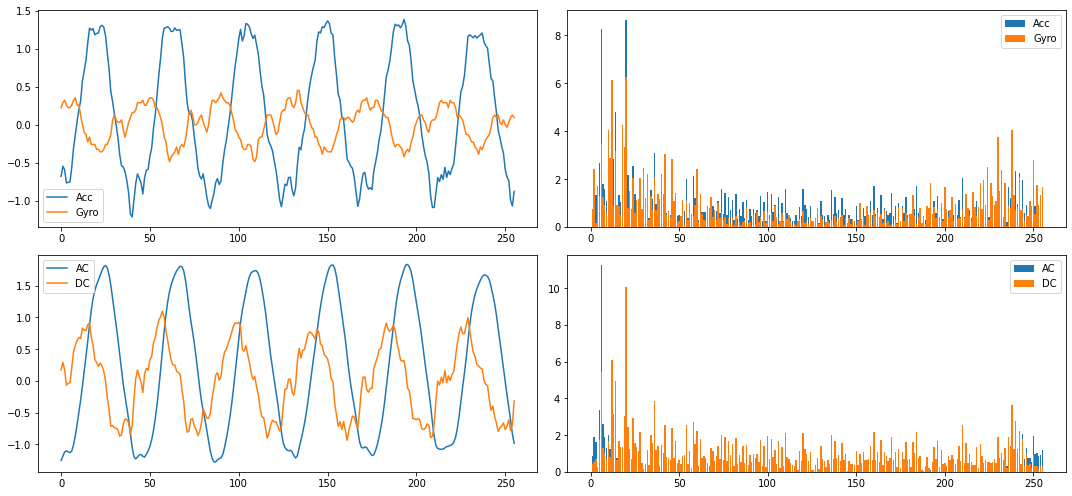

In [0]:
biking_ex = np.where(Y[0]==12)[0][10]#10th window of biking for subject 0

fig, ax = plt.subplots(2,2, figsize = (15,7))
ax[0,0].plot(SIGNALS[0][biking_ex, :, final_cols=="A_ankle_1"][0,:], label = "Acc")
ax[0,0].plot(SIGNALS[0][biking_ex, :, final_cols=="G_ankle_1"][0,:], label = "Gyro")
ax[0,0].legend()
ax[1,0].plot(SIGNALS[0][biking_ex, :, final_cols=="AC_ankle_1"][0,:], label = "AC")
ax[1,0].plot(SIGNALS[0][biking_ex, :, final_cols=="DC_ankle_1"][0,:], label = "DC")
ax[1,0].legend()
ax[0,1].bar(range(wl),
            np.abs(FT[0][biking_ex, :, final_cols=="A_ankle_1"][0,:]),
            label = "Acc")
ax[0,1].bar(range(wl), 
            np.abs(FT[0][biking_ex, :, final_cols=="G_ankle_1"][0,:]),
            label = "Gyro")
ax[0,1].legend()
ax[1,1].bar(range(wl), 
            np.abs(FT[0][biking_ex, :, final_cols=="AC_ankle_1"][0,:]), label = "AC")
ax[1,1].bar(range(wl), 
            np.abs(FT[0][biking_ex, :, final_cols=="DC_ankle_1"][0,:]),
            label = "DC")
ax[1,1].legend()
fig.tight_layout()


**Extracting features**

From each signal and for each window we extract features calculated in the temporal domain (statistical moments, different quantiles, range, zero crossing...) using the function *get_temporal_features()* as well as features in the frequency domain from the corresponding Fourier transform (enregy, entropy, centroid, bandwidth, max frequency) using *get_frequential_features()*.

In [0]:
FEATS = []
for i in range(n_subjs):
  X = SIGNALS[i]
  ft = FT[i]
  feats = np.zeros((X.shape[0], n_features*n_cols))
  for col in range(n_cols):
    temp_feats, temp_names = extract_temporal_features(X[:,:,col])#get features and names of features
    freq_feats, freq_names = extract_frequential_features(ft[:,:,col], sf)
    feats[:, (col*n_features):(col*n_features+n_features)] =\
     np.concatenate([temp_feats, freq_feats], axis = 1)
  FEATS.append(feats)
feat_names = [col+f_name for col in final_cols for f_name in temp_names + freq_names] #array of feature names

**Concatenating subject data into a single array**

In [0]:
SUBJ = np.repeat(range(n_subjs),[y.size for y in Y])
Y = np.concatenate(Y)
FEATS = np.concatenate(FEATS)
SIGNALS = np.concatenate(SIGNALS)
FT = np.concatenate(FT)

# **Hierachical classification using "classical" machine-learning algorithms**
---
We start by defining functions for instantiating classifiers using sklearn library:

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

def set_GB():
    return GradientBoostingClassifier(n_estimators = 500,
                                        max_features = 10, 
                                        max_depth = 3,
                                      n_iter_no_change = 5, 
                                      validation_fraction = 0.3, 
                                      learning_rate = 0.05)
def set_RF():
  return RandomForestClassifier(n_estimators = 500 , n_jobs=-1)
def set_logreg():
    return LogisticRegression(multi_class = "auto", penalty = 'l2', solver = "lbfgs", n_jobs = -1)
def set_SVM():
  return SVC()
def set_knn():
  return KNeighborsClassifier(n_neighbors = 5)

Before applying the hierarchical algorithm, let's try to apply a standard flat classification. Throughout this project, we apply a leave-one-subject-out procedure for testing. Testing the algorithm on a fraction of each subject's data might result in an upward bias, since  the algorithm was train on the *same* subject and has learnt patterns specific to the subject, and might not as well generlize to data from unseen subjects.

We illustrate the point with logistic regression. Comparaison with other models are reported in the article.

In [0]:
scores = []#list for score for each leave-one-out iteration
scaler = StandardScaler()
for i in range(19):
  mask = SUBJ==i#test subject
  X_train = scaler.fit_transform(FEATS[~mask, :])
  y_train = Y[~mask]
  clf = set_logreg() #logistic regression
  clf.fit(X_train, y_train)
  X_test = scaler.fit_transform(FEATS[mask,:])
  y_test = Y[mask]
  y_pred = clf.predict(X_test)#get 
  score = np.mean(y_test==y_pred)
  scores.append(score)
  print("accuracy tested on subject {}: {}".format(i, score))
print("mean accuracy: {}".format(np.mean(scores)))
print("standard deviation of accuracy: {}".format(np.std(scores)))

accuracy tested on subject 0: 0.9393305439330544
accuracy tested on subject 1: 0.935374149659864
accuracy tested on subject 2: 0.9791231732776617
accuracy tested on subject 3: 0.968944099378882
accuracy tested on subject 4: 0.9030303030303031
accuracy tested on subject 5: 0.9495412844036697
accuracy tested on subject 6: 0.9196078431372549
accuracy tested on subject 7: 0.9711751662971175
accuracy tested on subject 8: 0.9587628865979382
accuracy tested on subject 9: 0.9661733615221987
accuracy tested on subject 10: 0.9444444444444444
accuracy tested on subject 11: 0.9818548387096774
accuracy tested on subject 12: 0.9665970772442589
accuracy tested on subject 13: 0.9621052631578947
accuracy tested on subject 14: 0.9808510638297873
accuracy tested on subject 15: 0.93158953722334
accuracy tested on subject 16: 0.9357601713062098
accuracy tested on subject 17: 0.9798657718120806
accuracy tested on subject 18: 0.9688195991091314
mean accuracy: 0.9548921356881457
standard deviation of accuracy

**Hierarchical classification using logistic regression**

We get a fairly high classification accuracy. However, to better predict the final target classes, we want to apply a hierachical classification to the data. A first classifier assigns meta-classes to the samples, some of these meta-classes containing several similar target-classes (or sub-classes). Here, the procedures of hierarchical learning and predicting are wrapped in functions: *hierarchical_learn()* takes the training data and the hierarchical structure (list of lists) and returns a set of classifiers. These classifiers are passed to *hierarchical_predict()* along the data to be predicted, which returns a final vector of predicted target-classes. In the next section the procedure is explained step by step using CNN.  

We define the hierarchy of the models with the list of lists meta_classes:

```
meta_classes = [[1], [2], [3,4], [5,6], [7,8,9], [10], [11,12], [13]]
```
This hierarchy regroups similar sub-classes into one meta-classes: [3,4] for standing and doing the dishes, [5,6] for sweeping and vacuum cleaning etc.




In [0]:
meta_classes = [[1], [2], [3,4], [5,6], [7,8,9], [10], [11,12], [13]]#defining hierarchy
scores = []#list for score for each leave-one-out iteration
for i in range(19):
  mask = SUBJ==i#test subject
  X_train = FEATS[~mask, :]
  y_train = Y[~mask]
  #training hierarchical classifiers
  clfs = hierarchical_learn(set_logreg, meta_classes, X_train, y_train)#get base and meta-class specific classifiers
  X_test = FEATS[mask,:]
  y_test = Y[mask]
  y_pred = hierarchical_predict(X_test, clfs)#get 
  score = np.mean(y_test==y_pred)
  scores.append(score)
  print("accuracy tested on subject {}: {}".format(i, score))
print("mean accuracy: {}".format(np.mean(scores)))
print("standard deviation of accuracy: {}".format(np.std(scores)))

accuracy tested on subject 0: 0.9728033472803347
accuracy tested on subject 1: 0.9642857142857143
accuracy tested on subject 2: 0.9916492693110647
accuracy tested on subject 3: 0.9668737060041408
accuracy tested on subject 4: 0.9454545454545454
accuracy tested on subject 5: 0.9839449541284404
accuracy tested on subject 6: 0.9862745098039216
accuracy tested on subject 7: 0.9844789356984479
accuracy tested on subject 8: 0.9938144329896907
accuracy tested on subject 9: 0.9894291754756871
accuracy tested on subject 10: 0.9594017094017094
accuracy tested on subject 11: 0.9858870967741935
accuracy tested on subject 12: 0.9749478079331941
accuracy tested on subject 13: 0.9894736842105263
accuracy tested on subject 14: 0.9872340425531915
accuracy tested on subject 15: 0.9235412474849095
accuracy tested on subject 16: 0.9678800856531049
accuracy tested on subject 17: 0.9328859060402684
accuracy tested on subject 18: 0.9866369710467706
mean accuracy: 0.9729945863963082
standard deviation of accu

We reach a final accuracy of 97.3%, which is a significant imporvement on the flat classification and the highest accuracy score found sofar (start 2020) tested on unseen subjects.

**Hierachical modelling with CNN**
---
How do simple models such as logistic regression compare with heavier CNN models? 

We define a function for instantiating and compiling a cnn model. The model takes as input both the original signal and its Fourier transform. The architecture is the result of a some hyperparameter tuning, but other architectures are of course, possible. 

In [0]:
from keras.models import Model
from keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, BatchNormalization, Input, concatenate
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

def get_cnn(kern = 2**3, pool_size=2**4, n = 48, n_cols = 48, n_output = 13):
  """cnn with 1-layer of 1d convulutions with kern size (kern), max-pooling with
  size (pool_size). The model tunes n filters (n).
  Input: [raw signals shaped (window size, no. of signals (n_cols)), 
  fourier transform of the signals shaped (window size//2, no. of signals (n_cols))]
  Output: Matrices with prediction probabilities for n classes (n_output)
  """

  inp_raw = Input(shape=(int(wl), n_cols))
  inp_FT = Input(shape=(int(wl)//2, n_cols))

  raw = Conv1D(filters = n, kernel_size=kern, padding = "same", 
              activation='relu')(inp_raw)
  raw = BatchNormalization()(raw)
  raw = Conv1D(filters = n, kernel_size=kern, padding = "same", 
              activation='relu')(raw)
  raw = BatchNormalization()(raw)
  raw = MaxPooling1D(pool_size = pool_size, padding = "same")(raw)
  raw = Flatten()(raw)

  FT = Conv1D(filters = n, kernel_size=kern, padding = "same", 
              activation='relu')(inp_FT)
  FT = BatchNormalization()(FT)
  FT = Conv1D(filters = n, kernel_size=kern, padding = "same", 
              activation='relu')(FT)
  FT = BatchNormalization()(FT)
  FT = MaxPooling1D(pool_size = pool_size, padding = "same")(FT)
  FT = Flatten()(FT)
  # merge
  z = concatenate([raw, FT])
  z = Dropout(0.3)(z)
  z = BatchNormalization()(z)
  z = Dense(n_output, activation="softmax")(z)
  model = Model(inputs = [inp_raw, inp_FT], outputs = z)
  model.compile(optimizer='adam', loss = 'categorical_crossentropy',
                metrics = ['mse', 'accuracy'])
  return model

Using TensorFlow backend.


We divide our target classes into meta-classes using a list of lists

In [0]:
meta_classes = [[1], [2], [3,4], [5,6], [7,8,9], [10], [11,12], [13]]
mult_classes = [classes for classes in meta_classes if len(classes)>1] #meta-classs with several elements
map_dict = {i:mc[0] for mc in meta_classes for i in mc} # mapping dictionary from target-classes to meta-classes 
Y_ = np.array([map_dict[y] for y in Y])#mapping Y

**Selecting data**

We might want to try to predict the activities using only some of the sensors. Here, we select 3 of the 4 sensors: ankle, chest, and hip. A full comparison of the accuracy using different combinations of sensors is reported in the article. 

In [0]:
sensor_sel = pd.Index(final_cols).str.match(".*(ankle|chest|wrist)")#selecting some sensors
FT = np.abs(FT[:,:wl//2,sensor_sel])#we take the modulus of the Fourier transform (complex numbers) and discard the redundant half
SIGNALS = SIGNALS[:,:, sensor_sel]

For each step in the hierarchical classification, we call a new model. First, we perform a basic classification of samples into the meta-classes. Then, for each meta-classes comprising several sub-classes, we call a specific model distinguishing between the different sub-classes.

We iteratively train the data on all subjects but one, test on the subject left out, and average the results.  

In [0]:
esm = EarlyStopping(monitor = "val_accuracy", patience = 5, restore_best_weights=True)
#lists for storing confusion matrices and accuracy scores
all_group_scores, scores_all = [], []

for subj in range(19):
  group_scores = []
  print(subj)
  mask = SUBJ==subj #sample indices for test subject
  #basic classification
  X_train, X_test = [SIGNALS[~mask], FT[~mask]], [SIGNALS[mask], FT[mask]]#preparing data for cnn
  y_train = Y_[~mask] #target values for train subjects
  y_train = to_categorical(y_train) #one-hot encoding for target values
  y_base_true = Y_[mask] #target values for test
  clf_base = get_cnn(2**3, 2**4, X_train[0].shape[2], X_train[0].shape[2], y_train.shape[1]) #cnn model
  clf_base.fit(X_train, y_train, validation_split=0.3, epochs = 10, callbacks = [esm], verbose = 0)
  y_pred = clf_base.predict(X_test).argmax(axis = 1) #prediction as categorical vector
  score = np.mean(y_base_true==y_pred)
  print("base score: " +str (score))
  group_scores.append(score)
  
  for classes in mult_classes:
    inds = np.isin(Y, classes) #sample indices of meta-classes
    inds_pred = y_pred==classes[0] #which samples in test were predicted as belonging to this meta-class
    if inds_pred.sum()>0: #if there are any prediction for the group
      X_train, X_test = [SIGNALS[~mask & inds], 
                        FT[~mask & inds]], [SIGNALS[mask][inds_pred],
                                            FT[mask][inds_pred]]
      y_train = Y[~mask & inds]
      y_train = to_categorical(y_train)
      y_mc_true = Y[mask][inds_pred]
      clf_group = get_cnn(2**3, 2**4, X_train[0].shape[2], X_train[0].shape[2], y_train.shape[1])
      clf_group.fit(X_train, y_train, validation_split=0.3, epochs = 10, callbacks = [esm], verbose = 0)
      y_mc= clf_group.predict(X_test).argmax(axis = 1) #prediction as categorical vector
      y_pred[y_pred==classes[0]] = y_mc#updating final perdiction vector with prediction for metaclass
      score = np.mean(y_mc_true==y_mc)
      print(str(classes) + " score: " +str (score))
      group_scores.append(score)

  #overall
  y_true = Y[mask]
  score = np.mean(y_true==y_pred)
  print("overall score: " +str (score))
  scores_all.append(score)
  print("overall mean score:" +str(np.mean(scores_all)))
  print("standard deviation of accuracy: {}".format(np.std(scores)))
  all_group_scores.append(group_scores)

0
base score: 0.9937238493723849
[3, 4] score: 0.958904109589041
[5, 6] score: 0.9666666666666667
[7, 8, 9] score: 0.984375
[11, 12] score: 0.8958333333333334
overall score: 0.9644351464435147
overall mean score:0.9644351464435147
standard deviation of accuracy: 0.01979799153370542
1
base score: 0.9625850340136054
[3, 4] score: 0.9452054794520548
[5, 6] score: 0.7525773195876289
[7, 8, 9] score: 0.9809523809523809
[11, 12] score: 0.8163265306122449
overall score: 0.9115646258503401
overall mean score:0.9379998861469274
standard deviation of accuracy: 0.01979799153370542
2
base score: 1.0
[3, 4] score: 1.0
[5, 6] score: 1.0
[7, 8, 9] score: 0.9929577464788732
[11, 12] score: 0.8762886597938144
overall score: 0.9728601252609603
overall mean score:0.9496199658516051
standard deviation of accuracy: 0.01979799153370542
3
base score: 0.9875776397515528
[3, 4] score: 0.9473684210526315
[5, 6] score: 0.953125
[7, 8, 9] score: 1.0
[11, 12] score: 0.93
overall score: 0.9710144927536232
overall m

**Conclusion**

With around 95.8% mean accuracy, the CNN seems to perform well on our data. However, this score remains lower than the logistic regression based on carefully engineered features (97.3%). 

This differece becomes even more meaningful when we consider the *simplicity* and *versatility* of logistic regession. Unlike CNN, logtistic regrssion didn't require any hyperparameter tuning and is very fast to train. In another script, I show how the algorithm developed here to address the DaiLAc dataset performs, unmodified, on another dataset, the mHealth dataset. I clearly show that while logsistic regression and gradient boosting generalize very well and discriminate almost perfrectly between activities in the feature space (\<2% error), CNN performs poorly with around 12% error.

Although CNNs are very powerful and have the advantage of extracting features from data automatically, thus exempting the anaylst from having a deep understanding of the data, I show here that in terms of performance, time involved in hyperparameter tuning and training, as well as generalizibility, simpler models based on domain knowledge feature engineering can be a better alternative.